# AirBnB, Seattle Project

I decided to take up this project as I was interested to explore if certain besiness related insights can be gained by following a data-driven analytic approach. I was curious if the data can provide us clues to remain competitive in the market. This project is a part of the Data Science Nano Degree program provided by Udacity. The CRISP-DM (Cross Industry Process for Data Mining) process was followed as a guide for directing the entire pipeline from data to understanding. The steps in CRISP-DM process include:

1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modeling
5. Evaluation
6. Deploy

## Business Understanding

My primary interest was to explore if AirBnB data from a city can provide insights to remain competitive in the market. This could mean either if someone is looking into investing in a property or new/ existing user trying to come up with appropriate resource allocation plan to optimize profit margins. The big picture goal was taken up by splitting it into three specific questions:

1. What are the key features that determine the listing price?
2. What attributes can serve as determinants of customer influx?
3. Can property description serve as an indicator of price or customer traffic (how to best describe your listing)?

## Data Understanding

The AirBnB, Seattle listing data was explored to understand the details of what kind of information is included and how it can be harnessed to answer the specific questions.


In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import reqd_functions as rfnc

from collections import Counter
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
from wordcloud import WordCloud

%matplotlib inline

In [2]:
seattle_list = pd.read_csv("./seattle/listings.csv")
seattle_list.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


**All the given fields provided in listing data was explored to get an understanding of the formats and relevant features.**

In [45]:
seattle_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

## Data Preparation

**Preliminary exploreation of dataset revealed that the data is not clean and there are fields that may not be relevant for analysis. Also some of the numeric fields had characters that needed to be cleaned before it could be used.** 
The columns I am going to drop or modify include:

1. The URL fields except for 'thumbnail_url'.
2. Text fields except the property 'description'
3. Fields with redundant information such as availability\_[30, 60, 90]. Only availability_365 was retained. Similarly with weekly and monthly price. Only the 'price' field was retained.
4. The detailed split of review scores except the final rating.
5. More granualr aspects of location.
6. Columns with price amounts having '$' and ',' characters was cleaned.
7. Cleaned percentage columns with '%' character.
8. Converted thumnail data as available or not-available.
9. Converted host since from date to number of days.
10. Converted amenities column to number of amenities.


In [3]:
listing_df = seattle_list[['description','thumbnail_url','host_since','host_response_time','host_response_rate',
                           'host_acceptance_rate','host_has_profile_pic','host_identity_verified',
                           'neighbourhood_cleansed','neighbourhood_group_cleansed','property_type','room_type',
                           'accommodates','bathrooms','bedrooms','beds','bed_type','amenities','square_feet','price',
                           'security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights',
                           'maximum_nights','availability_365','number_of_reviews','review_scores_rating',
                           'instant_bookable','cancellation_policy','reviews_per_month']]

### Data preparation: Price

Based on the questions above two different set of features were required to carry out the analysis.
1. Using the identified relevant features except text description for predicting price.
2. Using the text description of property to see how effectively the price level could be predicted.

In [4]:
seattle_df = rfnc.clean_data(listing_df)
seattle_df.drop('description', axis=1, inplace=True)
seattle_df.head()

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,...,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,instant_bookable,cancellation_policy,reviews_per_month,thumbnail_available,amenities_count
0,1607.0,within a few hours,96.0,100.0,t,t,West Queen Anne,Queen Anne,Apartment,Entire home/apt,...,1,365,346,207,95.0,f,moderate,4.07,0,10
1,1047.0,within an hour,98.0,100.0,t,t,West Queen Anne,Queen Anne,Apartment,Entire home/apt,...,2,90,291,43,96.0,f,strict,1.48,1,16
2,571.0,within a few hours,67.0,100.0,t,t,West Queen Anne,Queen Anne,House,Entire home/apt,...,4,30,220,20,97.0,f,strict,1.15,0,21
3,789.0,NaN,NaN,NaN,t,t,West Queen Anne,Queen Anne,Apartment,Entire home/apt,...,1,1125,143,0,NaN,f,flexible,NaN,0,14
4,1497.0,within an hour,100.0,NaN,t,t,West Queen Anne,Queen Anne,House,Entire home/apt,...,1,1125,365,38,92.0,f,strict,0.89,0,13


** A. The dataframe was explored for missing values**

,feature,nan_count
13,beds,1
8,property_type,1
0,host_since,2
5,host_identity_verified,2
4,host_has_profile_pic,2
12,bedrooms,6
11,bathrooms,16
2,host_response_rate,523
1,host_response_time,523
28,reviews_per_month,627


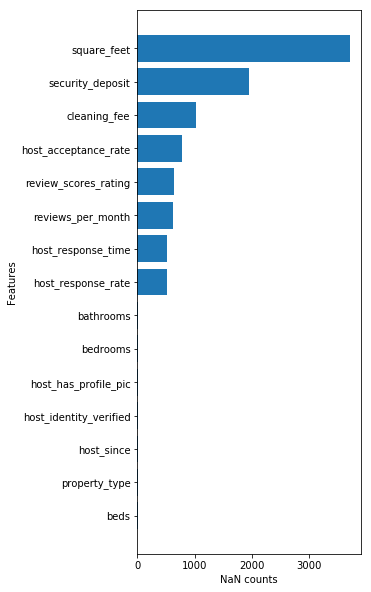

In [5]:
# Perform an assessment of how much missing data is there in each column of the dataset.

df_nans = seattle_df.isnull().sum()
data = [('feature', list(df_nans.index)), ('nan_count', list(df_nans.values))]
nan_counts = pd.DataFrame.from_items(data)

nan_counts = nan_counts.sort_values(by='nan_count')
display(nan_counts[nan_counts['nan_count'] != 0])

plt.figure(figsize=(4,10))
plt.barh(range(len(nan_counts[nan_counts['nan_count'] != 0])), nan_counts[nan_counts['nan_count'] != 0].nan_count.tolist())
plt.yticks(range(len(nan_counts[nan_counts['nan_count'] != 0])), nan_counts[nan_counts['nan_count'] != 0].feature.tolist())
plt.xlabel('NaN counts')
plt.ylabel('Features')

In [6]:
# Calculate percentage of missing data in columns
nan_percent = nan_counts['nan_count'].apply(lambda x : round(x/3818, 2)*100)
nan_counts['percent'] = nan_percent
display(nan_counts[nan_counts['nan_count'] > 0])

,feature,nan_count,percent
13,beds,1,0.0
8,property_type,1,0.0
0,host_since,2,0.0
5,host_identity_verified,2,0.0
4,host_has_profile_pic,2,0.0
12,bedrooms,6,0.0
11,bathrooms,16,0.0
2,host_response_rate,523,14.0
1,host_response_time,523,14.0
28,reviews_per_month,627,16.0


** B. Columns with relatively higher number of missing values were removed from analysis**

In [7]:
# Remove columns with relatively high percentage of missing values
clean_df = seattle_df.copy()
clean_df = clean_df[list(nan_counts[nan_counts['percent'] < 14.0]['feature'])]

** C. The price field was divided into two buckets based on the median value: 1) HIGH and 2) LOW**

In [8]:
# Split the data into features and target label
label_df = np.where(clean_df['price'] > clean_df['price'].median(), 0, 1)
feature_df = clean_df.drop(['price'], axis=1)

**D. The features dataframe was processed to impute missing values and then scaled for further analysis.** After dropping the columns with very high number of missing values, only columns with very few missing values were left (as can be observed from the data table above). So, the missing values were imputed using 'most frequent'.

In [9]:
scaled_df = rfnc.process_features(feature_df)

## Modeling and Evaluation: Price

More than one classifiers (SVM and Logistic Regression) were compared (data not shown here) before selecting the AdaBoostClassifier with decision tree base estimator. The model was optimized using GridSearchCV.

## What are the key features that determine the listing price?

In [10]:
# Initialize the classifier
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=42)

# Create the parameters list to tune, using a dictionary.
parameters = {"n_estimators": [10, 50, 100],
              "learning_rate": [0.005, .01, 0.05, 0.1, 0.5, 1],
             'base_estimator__min_samples_split' : [2, 4, 6, 8, 10], 
             'base_estimator__max_depth' : [2, 4, 6, 8, 10]}

In [11]:
best_clf, X_train, X_test, y_train, y_test = rfnc.boost_classifier(clf, parameters, scaled_df, label_df)

In [12]:
print(best_clf)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.1, n_estimators=100, random_state=42)


**The accuracy scores from Unoptimized and Optimized models are provied below: **

In [13]:
# Unoptimized model
test_accuracy, train_accuracy = rfnc.prediction_scores(clf, X_train, X_test, y_train, y_test)
rfnc.print_scores(test_accuracy, train_accuracy)

Accuracy score on testing data: 0.7382
Accuracy score on training data: 1.0000


In [14]:
# Optimized model
test_accuracy, train_accuracy = rfnc.prediction_scores(best_clf, X_train, X_test, y_train, y_test)
rfnc.print_scores(test_accuracy, train_accuracy)

Accuracy score on testing data: 0.7932
Accuracy score on training data: 0.8424


**The most improtant features that reflect the predictive performance are shown below:**


Top 10 features by importance
------


array(['accommodates', 'room_type_Entire home/apt', 'bedrooms',
       'availability_365', 'neighbourhood_group_cleansed_Downtown',
       'number_of_reviews', 'minimum_nights',
       'neighbourhood_group_cleansed_Capitol Hill', 'host_since',
       'neighbourhood_group_cleansed_Queen Anne'], dtype=object)

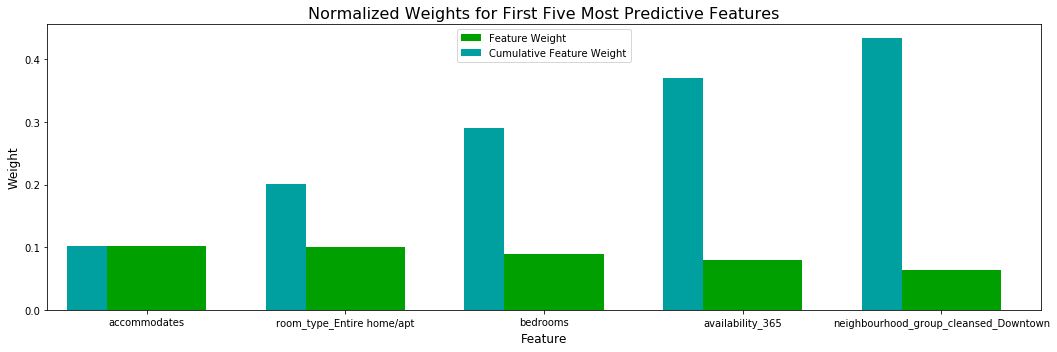

In [15]:
# Extract the feature importances using .feature_importances_ 
importances = best_clf.feature_importances_
indices = np.argsort(importances)[::-1]
print("\nTop 10 features by importance\n------")
display(X_train.columns.values[indices[:10]])

# Plot
rfnc.feature_plot(importances, X_train, y_train)

**The neighbourhood group field was explored to check the distribution based on price buckets:**

In [16]:
# Neighbourhood groups by price level (HIGH)
total_df = clean_df.copy()
total_df[total_df['price'] > total_df['price'].median()]['neighbourhood_group_cleansed'].value_counts()

Downtown               403
Other neighborhoods    338
Capitol Hill           288
Queen Anne             181
Central Area           180
West Seattle           106
Ballard                 96
Cascade                 49
Rainier Valley          42
Magnolia                38
Beacon Hill             33
University District     33
Northgate               21
Lake City               18
Seward Park             14
Delridge                14
Interbay                 4
Name: neighbourhood_group_cleansed, dtype: int64

In [17]:
# Neighbourhood groups by price level (LOW)
total_df = clean_df.copy()
total_df[total_df['price'] <= total_df['price'].median()]['neighbourhood_group_cleansed'].value_counts()

Other neighborhoods    456
Capitol Hill           279
Central Area           189
Ballard                134
Downtown               127
Rainier Valley         117
Queen Anne             114
West Seattle            97
University District     89
Beacon Hill             85
Delridge                65
Northgate               59
Lake City               49
Cascade                 40
Seward Park             30
Magnolia                23
Interbay                 7
Name: neighbourhood_group_cleansed, dtype: int64

## Can property description serve as an indicator of price?

### The text description of property was used to identify word level features using CountVectorizer.

In [18]:
# Analyze listing descriptions
desc_df = listing_df['description']

In [19]:
text_df = rfnc.create_text_features(desc_df)

In [20]:
text_df.head()

,00,000,10,100,1000,100mbps,105,10am,10min,10pm,...,youtube,yummy,zagat,zen,zero,zip,zipcar,zone,zoned,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### The model was optimized using GridSearchCV.

In [21]:
# Initialize the classifier
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=42)

# Create the parameters list to tune, using a dictionary.
parameters = {"n_estimators": [10, 50, 100],
              "learning_rate": [.01, 0.05, 0.1, 0.5, 1],
             'base_estimator__min_samples_split' : [2, 4, 6, 8, 10], 
             'base_estimator__max_depth' : [2, 4, 6, 8, 10]}

best_clf, X_train, X_test, y_train, y_test = rfnc.boost_classifier(clf, parameters, text_df, label_df)

In [22]:
print(best_clf)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.05, n_estimators=100, random_state=42)


### The accuracy scores from Unoptimized and Optimized models are provied below:

In [23]:
# Unoptimized model
test_accuracy, train_accuracy = rfnc.prediction_scores(clf, X_train, X_test, y_train, y_test)
rfnc.print_scores(test_accuracy, train_accuracy)

Accuracy score on testing data: 0.6972
Accuracy score on training data: 0.9996


In [24]:
# Optimized model
test_accuracy, train_accuracy = rfnc.prediction_scores(best_clf, X_train, X_test, y_train, y_test)
rfnc.print_scores(test_accuracy, train_accuracy)

Accuracy score on testing data: 0.7120
Accuracy score on training data: 0.7803


### A word cloud of top 50 important word level features are shown below:


Top 50 features by importance
------


array(['shared', 'room', 'bedrooms', 'views', 'beds', 'bathroom', 'king',
       'private', 'gas', 'master', 'market', 'queen', 'sleeper', 'pike',
       'modern', 'bed', 'appliances', 'condo', 'share', 'bus', 'unit',
       'perfect', 'tea', 'studio', 'coffee', 'breakfast', 'of', 'my',
       'families', 'capitol', 'bedroom', 'stores', 'the', 'sleeps', 'help',
       'deck', 'hangers', 'stainless', 'out', 'lamp', 'everything', 'hill',
       'luxury', 'access', 'have', 'them', 'buses', 'including', 'size',
       '15'], dtype=object)

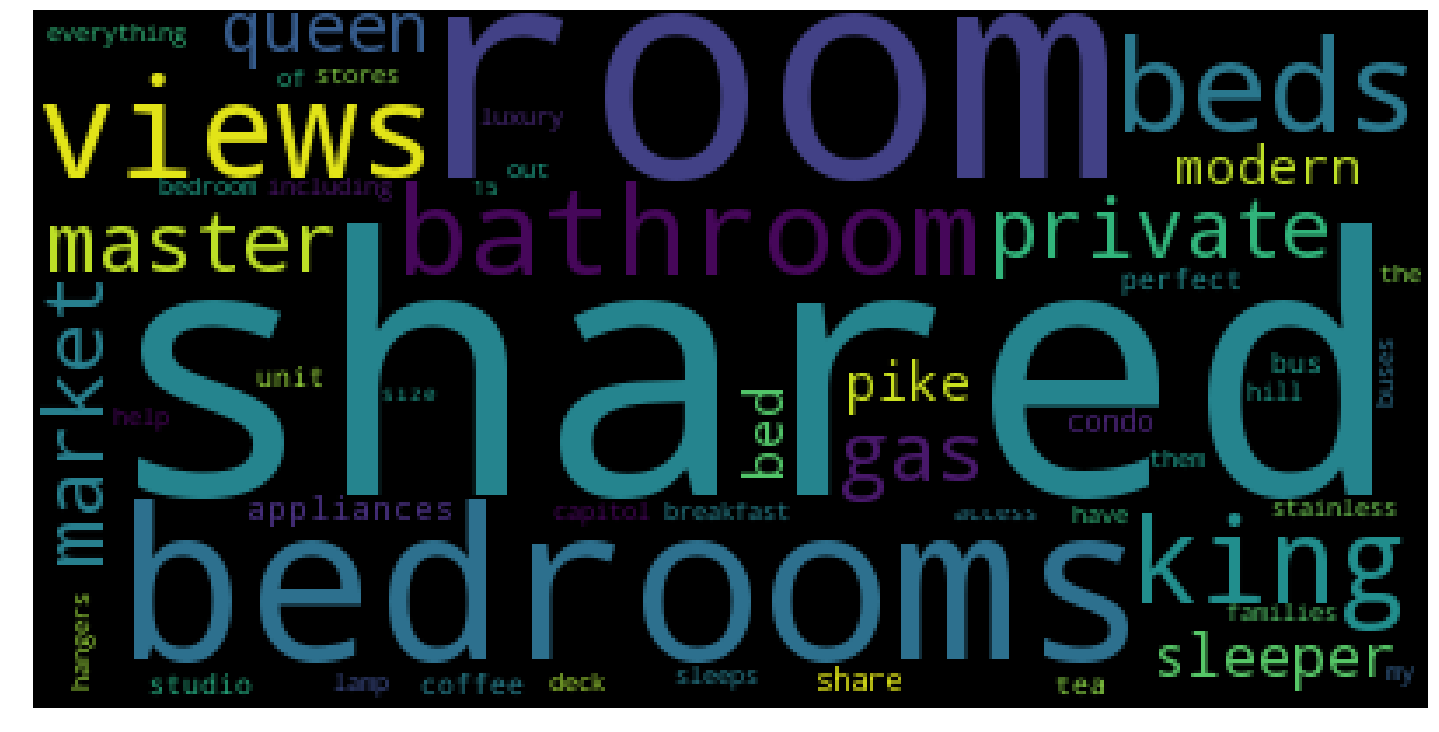

In [25]:
# Extract the feature importances using .feature_importances_ 
importances = best_clf.feature_importances_
indices = np.argsort(importances)[::-1]
print("\nTop 50 features by importance\n------")
display(X_train.columns.values[indices[:50]])

# WordCloud
rfnc.create_wordcloud(importances, X_train, y_train)

## What attributes can serve as determinants of customer influx?

**The number of reivews per month was used as a proxy for customer influx.**

**Similary process of cleaning and data preparation was used as decribed above.**

In [26]:
reviews_df = listing_df[listing_df['reviews_per_month'].isnull() != True]

In [27]:
rev_num_df = rfnc.clean_data(reviews_df)
rev_num_df.drop('description', axis=1, inplace=True)
display(rev_num_df.head())
display(rev_num_df.shape)

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,...,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,instant_bookable,cancellation_policy,reviews_per_month,thumbnail_available,amenities_count
0,1607,within a few hours,96.0,100.0,t,t,West Queen Anne,Queen Anne,Apartment,Entire home/apt,...,1,365,346,207,95.0,f,moderate,4.07,0,10
1,1047,within an hour,98.0,100.0,t,t,West Queen Anne,Queen Anne,Apartment,Entire home/apt,...,2,90,291,43,96.0,f,strict,1.48,1,16
2,571,within a few hours,67.0,100.0,t,t,West Queen Anne,Queen Anne,House,Entire home/apt,...,4,30,220,20,97.0,f,strict,1.15,0,21
4,1497,within an hour,100.0,NaN,t,t,West Queen Anne,Queen Anne,House,Entire home/apt,...,1,1125,365,38,92.0,f,strict,0.89,0,13
5,1836,NaN,NaN,NaN,t,t,West Queen Anne,Queen Anne,House,Private room,...,1,6,302,17,95.0,f,strict,2.45,1,6


(3191, 31)

### Assessment of Missing Data

,feature,nan_count
12,bedrooms,6
11,bathrooms,12
25,review_scores_rating,20
2,host_response_rate,320
1,host_response_time,320
3,host_acceptance_rate,486
18,cleaning_fee,768
17,security_deposit,1575
15,square_feet,3099


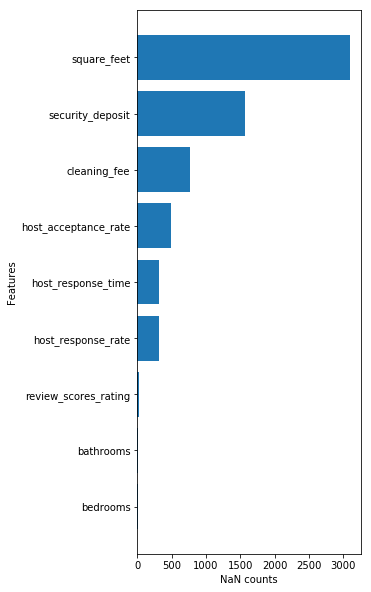

In [28]:
# Perform an assessment of how much missing data is there in each column of the dataset.

df_nans = rev_num_df.isnull().sum()
data = [('feature', list(df_nans.index)), ('nan_count', list(df_nans.values))]
nan_counts = pd.DataFrame.from_items(data)

nan_counts = nan_counts.sort_values(by='nan_count')
display(nan_counts[nan_counts['nan_count'] != 0])

plt.figure(figsize=(4,10))
plt.barh(range(len(nan_counts[nan_counts['nan_count'] != 0])), nan_counts[nan_counts['nan_count'] != 0].nan_count.tolist())
plt.yticks(range(len(nan_counts[nan_counts['nan_count'] != 0])), nan_counts[nan_counts['nan_count'] != 0].feature.tolist())
plt.xlabel('NaN counts')
plt.ylabel('Features')

In [29]:
# Calculate percentage of missing data in columns
nan_percent = nan_counts['nan_count'].apply(lambda x : round(x/3191, 2)*100)
nan_counts['percent'] = nan_percent
display(nan_counts[nan_counts['nan_count'] > 0])

,feature,nan_count,percent
12,bedrooms,6,0.0
11,bathrooms,12,0.0
25,review_scores_rating,20,1.0
2,host_response_rate,320,10.0
1,host_response_time,320,10.0
3,host_acceptance_rate,486,15.0
18,cleaning_fee,768,24.0
17,security_deposit,1575,49.0
15,square_feet,3099,97.0


In [30]:
# Remove columns with relatively high percentage of missing values
rev_num_df = rev_num_df[list(nan_counts[nan_counts['percent'] < 10.0]['feature'])]

## Modeling and Evaluation: Customer traffic

### Converting label variable into two buckets using median: HIGH and LOW

In [31]:
# Split the data into features and target label
labels = np.where(rev_num_df['reviews_per_month'] > rev_num_df['reviews_per_month'].median(), 0, 1)
feature_df = rev_num_df.drop(['reviews_per_month'], axis=1)

In [32]:
scaled_df = rfnc.process_features(feature_df)

### Model optimization using GridSearchCV

In [33]:
# Initialize the classifier
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=42)

# Create the parameters list to tune, using a dictionary.
parameters = {"n_estimators": [10, 50, 100],
              "learning_rate": [0.005, .01, 0.05, 0.1, 0.5, 1],
             'base_estimator__min_samples_split' : [2, 4, 6, 8, 10], 
             'base_estimator__max_depth' : [2, 4, 6, 8, 10]}

In [34]:
best_clf, X_train, X_test, y_train, y_test = rfnc.boost_classifier(clf, parameters, scaled_df, labels)

In [35]:
print(best_clf)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=8,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.05, n_estimators=50, random_state=42)


### Comparison of Accuracy scores from Unoptimized and Optimized models

In [36]:
# Unoptimized model
test_accuracy, train_accuracy = rfnc.prediction_scores(clf, X_train, X_test, y_train, y_test)
rfnc.print_scores(test_accuracy, train_accuracy)

Accuracy score on testing data: 0.7745
Accuracy score on training data: 1.0000


In [37]:
# Optimized model
test_accuracy, train_accuracy = rfnc.prediction_scores(best_clf, X_train, X_test, y_train, y_test)
rfnc.print_scores(test_accuracy, train_accuracy)

Accuracy score on testing data: 0.8601
Accuracy score on training data: 0.9136


### Top features that determine the customer traffic


Top 10 features by importance
------


array(['number_of_reviews', 'host_since', 'availability_365',
       'amenities_count', 'price', 'minimum_nights', 'maximum_nights',
       'review_scores_rating', 'extra_people', 'bathrooms'], dtype=object)

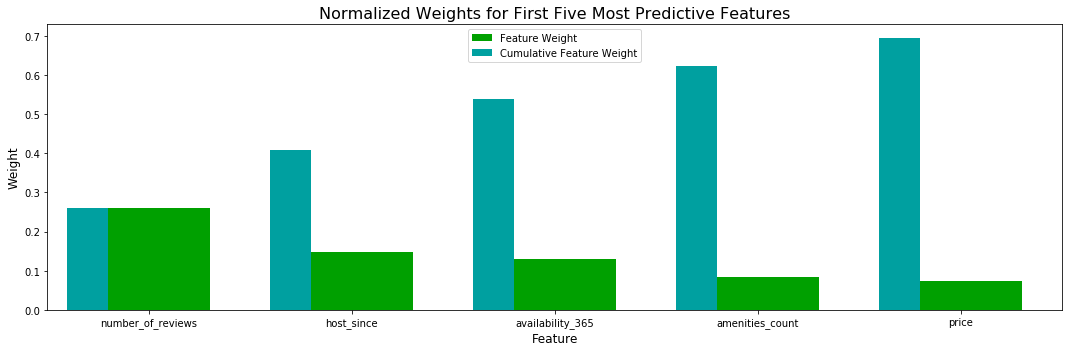

In [38]:
# Extract the feature importances using .feature_importances_ 
importances = best_clf.feature_importances_
indices = np.argsort(importances)[::-1]
print("\nTop 10 features by importance\n------")
display(X_train.columns.values[indices[:10]])

# Plot
rfnc.feature_plot(importances, X_train, y_train)

## Can property description serve as an indicator of customer traffic?

### The text description of property was used to identify word level features using CountVectorizer.

In [39]:
# Analyze listing descriptions
desc_df = reviews_df['description']
text_df = rfnc.create_text_features(desc_df)

In [40]:
text_df.head()

,00,000,10,100,1000,100mbps,10min,10pm,10th,11,...,yourself,yourselves,youtube,zagat,zen,zero,zip,zipcar,zone,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Model optimization using GridSearchCV

In [41]:
# Initialize the classifier
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=42)

# Create the parameters list to tune, using a dictionary.
parameters = {"n_estimators": [10, 50, 100],
              "learning_rate": [.01, 0.05, 0.1, 0.5, 1],
             'base_estimator__min_samples_split' : [2, 4, 6, 8, 10], 
             'base_estimator__max_depth' : [2, 4, 6, 8, 10]}

best_clf, X_train, X_test, y_train, y_test = rfnc.boost_classifier(clf, parameters, text_df, labels)
print(best_clf)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.1, n_estimators=50, random_state=42)


### Comparison of Accuracy scores from Unoptimized and Optimized model:

In [42]:
# Unoptimized model
test_accuracy, train_accuracy = rfnc.prediction_scores(clf, X_train, X_test, y_train, y_test)
rfnc.print_scores(test_accuracy, train_accuracy)

Accuracy score on testing data: 0.5939
Accuracy score on training data: 0.9973


In [43]:
# Optimized model
test_accuracy, train_accuracy = rfnc.prediction_scores(best_clf, X_train, X_test, y_train, y_test)
rfnc.print_scores(test_accuracy, train_accuracy)

Accuracy score on testing data: 0.6441
Accuracy score on training data: 0.7250


### Word cloud showing top 50 word level features by importance:


Top 50 features by importance
------


array(['fan', 'tea', 'private', 'master', 'bedrooms', 'code', 'convention',
       'place', 'the', 'microsoft', 'towels', 'condo', 'free', 'want',
       'bathrooms', 'studio', 'entrance', 'shampoo', 'space', 'newly',
       'coffee', 'closet', 'washington', 'qfc', 'not', 'fold', 'property',
       'and', 'sights', 'bathroom', 'living', 'children', 'topper',
       'detached', 'box', 'gilman', 'this', 'updated', 'area', 'problems',
       'provided', 'wi', 'body', 'retreat', 'check', 'of', 'entry',
       'cooking', 'kitchenette', 'pine'], dtype=object)

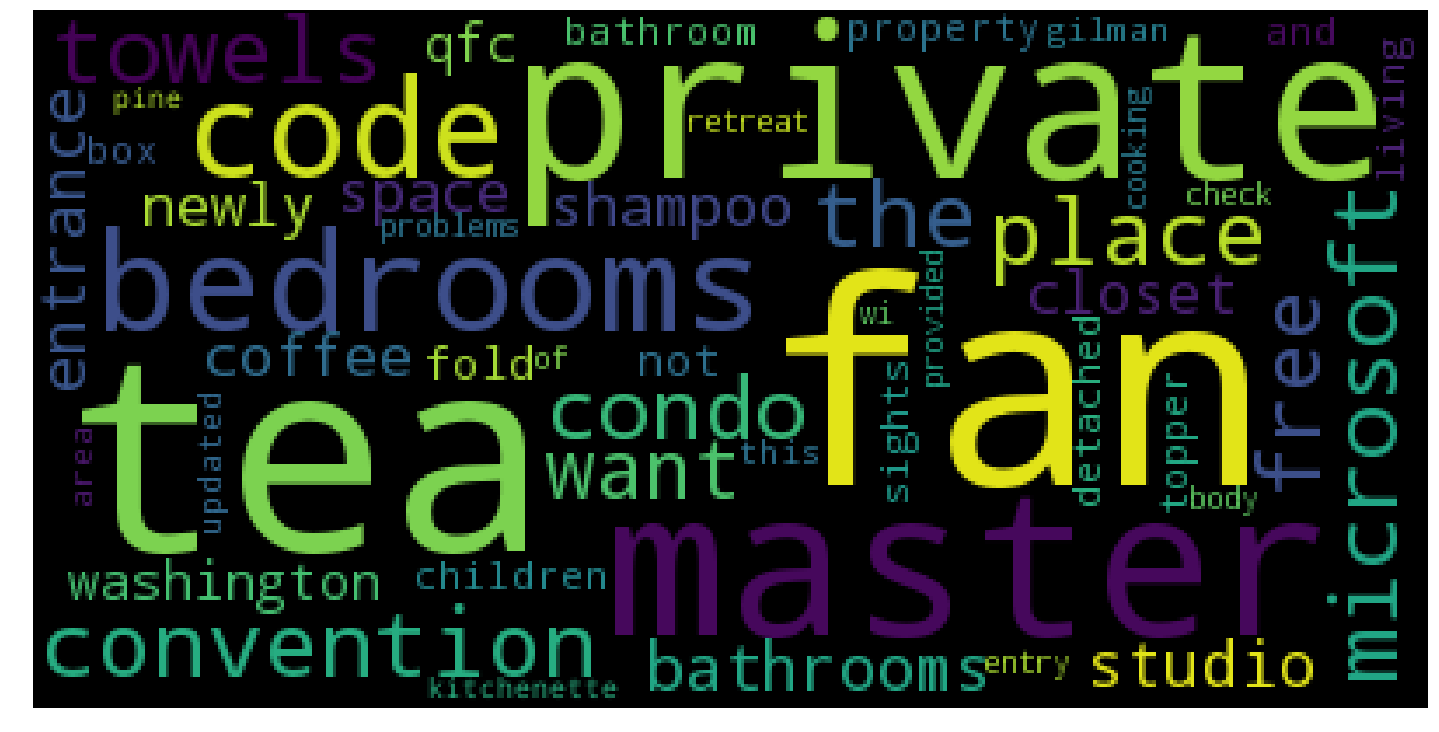

In [44]:
# Extract the feature importances using .feature_importances_ 
importances = best_clf.feature_importances_
indices = np.argsort(importances)[::-1]
print("\nTop 50 features by importance\n------")
display(X_train.columns.values[indices[:50]])

# WordCloud
rfnc.create_wordcloud(importances, X_train, y_train)

## Deployment

### The results and insights from the project is published here.

## Conclusion

The specific details from analysis are described in above sections, but following key aspects are reflected from the data:

1. Neighborhood groups play an important role in price determination. However, in combination with other features of listing the price can be set to gain suitable profit margins. 

2. The amenities provided and flexibility to accommodate guests can be distinguish features that guide customer flow.

3. Writing creative and resonant descriptions of listings with proper portrayal of key features can be helpful to remain competitive.